# How to rediscover the Higgs boson yourself! - BDT
This notebook uses ATLAS Open Data http://opendata.atlas.cern to show you the steps to rediscover the Higgs boson yourself!

The idea is that you improve upon the example BDT to increase the ratio of signal ($H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$) to background ($Z, t\bar{t}, ZZ \rightarrow \ell\ell\ell\ell$)

First, try to reduce the amount of $Z$ and $t\bar{t}$ background, since these are quite different to the signal.

Then, try to reduce the amount of $ZZ \rightarrow \ell\ell\ell\ell$, whilst keeping $H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$ signal

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

This notebook was inspired by https://betatim.github.io/posts/sklearn-for-TMVA-users/

<!-- <CENTER><img src="../HZZ_feynman.pdf" style="width:40%"></CENTER> -->

## First time setup
This first cell only needs to be run the first time you open this notebook on your computer. 

If you close jupyter and re-open on the same computer, you won't need to run this first cell again.

If you re-open on binder, you will need to run this cell again.

If you run into a problem of "uproot not being available", Kernel -> Restart & Run All

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip
!{sys.executable} -m pip install -U numpy pandas uproot matplotlib keras scikit-learn --user

## To setup everytime
Cell -> Run All Below

to be done every time you re-open this notebook

In [2]:
import uproot
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import infofile

In [3]:
lumi = 1000
                                                                                                                                  
tuple_path = "../Input/"

stack_order = ['data',r'$Z,t\bar{t}$','ZZ',r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']

In [4]:
samples = {

    'data': {
        'list' : ['DataEgamma','DataMuons']
    },

    r'$Z,t\bar{t}$' : {
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#8700da"
    },

    'ZZ' : {
        'list' : ['ZZ'],
        'color' : "#f90000"
    },

    r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$' : {
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep'],
        'color' : "#4faeff"
    }

}

In [5]:
def get_data_from_files():

    data = {}

    for s in samples:
        print(s+':')
        frames = []
        for val in samples[s]['list']:
            prefix = "MC/skim.mc_"
            if s == 'data':
                prefix = "Data/skim."
            else: prefix += str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".root"
            print(fileString)
            f = glob.glob(fileString,recursive=False)[0]
            if f != "":
                temp = read_file(f,val)
                frames.append(temp)
            else:
                print("Error: "+val+" not found!")
        data[s] = pd.concat(frames)

    return data

In [6]:
def mllll_window(mllll):
    return 120 < mllll < 130

In [7]:
def calc_weight(mcWeight,scaleFactor_PILEUP,scaleFactor_ELE,
                scaleFactor_MUON, scaleFactor_TRIGGER):
    return mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER

In [8]:
def get_xsec_weight(totalWeight,sample):
    info = infofile.infos[sample]
    weight = (lumi*info["xsec"])/(info["sumw"]*info["red_eff"])
    weight *= totalWeight
    return weight

## Plotting Variables and Correlations

The <span style="color:red">pandas</span> library provides high-performance, easy-to-use data structures and data analysis tools written in python. We will use it for its plotting capabilities and other nice ways to explore your data.

A <span style="color:red">DataFrame</span> is a 2-dimensional labeled data structure with columns of potentially different types. You can think of it like a spreadsheet.

In [10]:
def plot_data(data):

    mc_weights = []
    mc_colors = []
    mc_labels = []

    for s in stack_order:
        if s != "data":
            mc_labels.append(s)
            mc_colors.append(samples[s]['color'])
    
    # scatter plot of signal and background lep_n vs mllll
    # need to remove lep_n from drop at end of read_file function for this to work
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': plt.scatter(data[s].lep_n,data[s].mllll,color=samples[s]['color'],label=s)
    #plt.xlabel(r'Leptons',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
    #plt.ylabel(r'$M_{\ell\ell\ell\ell}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)
    #plt.legend()
    
    # scatter plot of signal and background lep_pt[0] vs mllll
    # need to remove lep_pt from drop at end of read_file function for this to work
    #plt.figure()
    #for s in stack_order:
    #    if s != 'data': plt.scatter(data[s].lep_pt.apply(lambda x: x[0]),data[s].mllll,color=samples[s]['color'],label=s)
    #plt.legend()
    
    # plot correlation matrices for signal and background
    # remove variables from drop at end of read_file function to see their correlations
    #correlations(pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ']]),"background")
    #correlations(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'], "signal")

    return

## Correlation Matrix
The correlation between features can be plotted with <span style="color:red">df.corr()</span>. 

In [11]:
def correlations(data, title, **kwds):
    """Calculate pairwise correlation between features.
    
    Extra arguments are passed on to DataFrame.corr()
    """
    # simply call df.corr() to get a table of
    # correlation values if you do not need
    # the fancy plotting
    corrmat = data.corr(**kwds)

    fig, ax1 = plt.subplots(ncols=1, figsize=(6,5))
    
    opts = {'cmap': plt.get_cmap("RdBu"),
            'vmin': -1, 'vmax': +1}
    heatmap1 = ax1.pcolor(corrmat, **opts)
    plt.colorbar(heatmap1, ax=ax1)

    ax1.set_title(title+" Correlations")

    labels = corrmat.columns.values
    for ax in (ax1,):
        # shift location of ticks to center of the bins
        ax.set_xticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_yticks(np.arange(len(labels))+0.5, minor=False)
        ax.set_xticklabels(labels, minor=False, ha='right', rotation=70)
        ax.set_yticklabels(labels, minor=False)
        
    plt.tight_layout()

In [12]:
def calc_mllll(lep_pts,lep_etas,lep_phis):
    theta_0 = 2*math.atan(math.exp(-lep_etas[0]))
    theta_1 = 2*math.atan(math.exp(-lep_etas[1]))
    theta_2 = 2*math.atan(math.exp(-lep_etas[2]))
    theta_3 = 2*math.atan(math.exp(-lep_etas[3]))
    p_0 = lep_pts[0]/math.sin(theta_0)
    p_1 = lep_pts[1]/math.sin(theta_1)
    p_2 = lep_pts[2]/math.sin(theta_2)
    p_3 = lep_pts[3]/math.sin(theta_3)
    pz_0 = p_0*math.cos(theta_0)
    pz_1 = p_1*math.cos(theta_1)
    pz_2 = p_2*math.cos(theta_2)
    pz_3 = p_3*math.cos(theta_3)
    px_0 = p_0*math.sin(theta_0)*math.cos(lep_phis[0])
    px_1 = p_1*math.sin(theta_1)*math.cos(lep_phis[1])
    px_2 = p_2*math.sin(theta_2)*math.cos(lep_phis[2])
    px_3 = p_3*math.sin(theta_3)*math.cos(lep_phis[3])
    py_0 = p_0*math.sin(theta_0)*math.sin(lep_phis[0])
    py_1 = p_1*math.sin(theta_1)*math.sin(lep_phis[1])
    py_2 = p_2*math.sin(theta_2)*math.sin(lep_phis[2])
    py_3 = p_3*math.sin(theta_3)*math.sin(lep_phis[3])
    sumpz = pz_0 + pz_1 + pz_2 + pz_3
    sumpx = px_0 + px_1 + px_2 + px_3
    sumpy = py_0 + py_1 + py_2 + py_3
    sumE = p_0 + p_1 + p_2 + p_3
    mllll = sumE**2 - sumpz**2 - sumpx**2 - sumpy**2
    return math.sqrt(mllll)/1000.

In [14]:
def calc_mll(lep_pts,lep_etas,lep_phis):
    # this is only pseudo-code to tell you what to do!
    # you need to decide how to find i & j yourself
    mll = 2*lep_pts[i]*lep_pts[j!=i]
    cosh = math.cosh(lep_etas[i]-lep_etas[j!=i])
    cos = math.cos(lep_phis[i]-lep_phis[j!=i])
    mll *= ( cosh - cos )
    return math.sqrt(mll)/1000.

## Uncommenting a new cut
If you add a cut: Cell -> Run All Below

In [15]:
def read_file(path,sample):
    start = time.time()
    print("\tProcessing: "+sample)
    mc = uproot.open(path)["mini"]
#     data = mc.pandas.df(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
#                          "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
#                          "scaleFactor_TRIGGER"], flatten=False)
    data = pd.DataFrame(mc.arrays(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased",
                         "mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON", # add more variables here if you make cuts on them
                         "scaleFactor_TRIGGER"], library ='np') #,columns = ["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased","mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"]
                       )

    nIn = len(data.index)

    if 'Data' not in sample:
        data['totalWeight'] = np.vectorize(calc_weight)(data.mcWeight,data.scaleFactor_PILEUP,data.scaleFactor_ELE,data.scaleFactor_MUON,data.scaleFactor_TRIGGER)
        data['totalWeight'] = np.vectorize(get_xsec_weight)(data.totalWeight,sample)

    data.drop(["mcWeight","scaleFactor_PILEUP","scaleFactor_ELE","scaleFactor_MUON","scaleFactor_TRIGGER"], axis=1, inplace=True)
    
    # cut on minimum lepton pt
    
    # cut on lepton etcone20
    
    # cut on lepton d0
    
    # example of adding column that takes the return of the function cut_lep_pt_min
    #data['lep_pt_min'] = data.apply(cut_lep_pt_min,axis=1)
    
    # example of cut on minimum number of leptons passing baseline requirements
    #fail = data[ np.vectorize(cut_n_lep_min)(data.lep_pt_min) ].index
    #data.drop(fail, inplace=True)
    
    # cut on number of leptons
    fail = data[ np.vectorize(cut_n_lep)(data.lep_n) ].index
    data.drop(fail, inplace=True)

    # cut on lepton charge
    #fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index
    #data.drop(fail, inplace=True)
    
    #print(data)
    
    # cut on lepton type
    #fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index
    #data.drop(fail, inplace=True)
    
    # cut on lepton pt
    #fail = data[ np.vectorize(cut_lep_pt)(data.lep_pt) ].index
    #data.drop(fail, inplace=True)
    
    # cut on deltaR
    #fail = data[ np.vectorize(cut_deltaR)(data.lep_eta,data.lep_phi...
    #data.drop(fail, inplace=True)
    
    # cut on minimum opposite-charge-same-type lepton pair invariant mass
    #fail = data[ np.vectorize(cut_OCST)(data....

    # calculation of Z boson candidate 1 invariant mass
    #data['mZ1'] = np.vectorize(calc_mZ1)(data.lep_pt,data.lep_eta,data.lep_phi)
    
    # cut on mZ1
    #fail = data[ np.vectorize(cut_mZ1)(data.mZ1) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of Z boson candidate 2 invariant mass
    #data['mZ2'] = np.vectorize(calc_mZ2)(data....
    
    # cut on mZ2
    #fail = data[ np.vectorize(cut_mZ2)(data.mZ2) ].index
    #data.drop(fail, inplace=True)
    
    # calculation of 4-lepton invariant mass
    data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi)

    mllll_window_list = data[ np.vectorize(mllll_window)(data.mllll) ] # return events with 120 < mllll < 130 GeV
    
    # example of expanding lep_pt list column into individual columns whilst requiring exactly 4 leptons
    # need to change cut_lep_n to require exactly 4 leptons
    #data[['lep1_pt','lep2_pt','lep3_pt','lep4_pt']] = pd.DataFrame(data.lep_pt.values.tolist(), index= data.index)

    # example of expanding lep_pt list column into individual columns without requiring exactly 4 leptons
    # need to do this for columns that you wish to use for fit_BDT
    #if max(data.lep_n) < 5: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt'], index=data.index)
    #    df_split['lep5_pt'] = 0
    #    df_split['lep6_pt'] = 0
    #elif max(data.lep_n) < 6: 
    #    df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt'], index=data.index)
    #    df_split['lep6_pt'] = 0
    #else: df_split = pd.DataFrame(data['lep_pt'].values.tolist(), columns=['lep1_pt','lep2_pt','lep3_pt','lep4_pt','lep5_pt','lep6_pt'], index=data.index)
    #df_split.fillna(0, inplace=True)
    #data = pd.concat([data, df_split], axis=1)
    
    #print(data)
    
    # if you want a variable to be input into your BDT, remove it from the drop function
    data.drop(["lep_n","lep_pt","lep_eta","lep_phi","lep_charge","lep_type","lep_etcone20","lep_trackd0pvunbiased","lep_tracksigd0pvunbiased"], axis=1, inplace=True)  
    
    # totalWeight needs to be dropped if you want to do bdt
    # if this is done, need to comment out plot_data(data) in bottom cell
    if 'Data' not in sample: data.drop(["totalWeight"], axis=1, inplace=True)

    nOut = len(data.index)

    elapsed = time.time() - start
    print("\t\tTime taken: "+str(elapsed)+", nIn: "+str(nIn)+", nOut: "+str(nOut))
    
    return data

## Changing an already uncommented cut

If you change a cut: Cell -> Run All Below

If you uncomment a cut here, you also need to uncomment the corresponding cut in the cell above.

In [16]:
# cut on number of leptons
def cut_n_lep(lep_n):
    # return when number of leptons is less than 4
    return lep_n < 4

# cut on lepton charge
def cut_lep_charge(lep_charge):
    # return when sum of lepton charges is not equal to 0
    # exclamation mark (!) means "not"
    # so != means "not equal to"
    # first lepton is [0], 2nd lepton is [1] etc
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0

# cut on lepton type
def cut_lep_type(lep_type):
# for an electron lep_type is 11
# for a muon lep_type is 13
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 44) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 48) and (lep_type[0]+lep_type[1]+lep_type[2]+lep_type[3] != 52)

# cut on lepton pt
#def cut_lep_pt(lep_pt):
# want to throw away events where the 2nd highest pt lepton used has lep_pt[1] < 15000
# want to throw away events where the 3rd highest pt lepton used has lep_pt[2] < 10000

# cut on minimum opposite-charge-same-type lepton pair invariant mass
#def cut_mOCST():
# want to throw away events if the invariant mass of any opposite-charge-same-type lepton pair is < 5

# cut on invariant mass of Z boson candidate 1
#def cut_mZ1(mZ1):
# want invariant mass of same-type-opposite-charge lepton pair that's closest to Z mass (91 GeV) to be in range 50 < m < 106 GeV

# cut on invariant mass of Z boson candidate 2
#def cut_mZ2(mZ2):
# want invariant mass of remaining lepton pair that's closest to Z mass (91 GeV) to be in range 17.5 < m < 115 GeV
# advanced: vary the lower range monotically from 17.5 at mllll=120 to 50 at mllll=190, and constant above mllll=190

# cut on deltaR
# want to throw away leptons that are separated from all other leptons by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.2
# want to throw away leptons that are separated from other leptons of the same type by deltaR = math.sqrt(delta(lep_eta)**2 + delta(lep_phi)**2) < 0.1

# example of returning list where every element passes minimum lep_pt requirement
#def cut_lep_pt_min(data):
#    return [data.lep_pt[i] for i in range(len(data.lep_pt)) if data.lep_pt[i] > 6000]

# cut on minimum lepton pt
# want to throw away muons with lep_pt < 6000
# want to throw away electrons with lep_pt < 7000

# cut on maximum lepton etcone20
# want to throw away muons with lep_etcone20/lep_pt < 0.3
# want to throw away electrons with lep_etcone20/lep_pt < 0.2

# cut on maximum lepton d0
# want to throw away muons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 3.5
# want to throw away electrons with lep_trackd0pvunbiased/lep_tracksigd0pvunbiased < 6.5

# example of cutting on length of list passing minimum requirements
#def cut_n_lep_min(lep_pt_min):
#    return len(lep_pt_min) < 4

In [17]:
if __name__=="__main__":
    start = time.time()
    data = get_data_from_files()
    #plot_data(data)
    elapsed = time.time() - start
    print("Time taken: "+str(elapsed))

data:
../Input/Data/skim.DataEgamma.root
	Processing: DataEgamma
		Time taken: 0.053891897201538086, nIn: 89, nOut: 89
../Input/Data/skim.DataMuons.root
	Processing: DataMuons
		Time taken: 0.04484295845031738, nIn: 112, nOut: 112
$Z,t\bar{t}$:
../Input/MC/skim.mc_147770.Zee.root
	Processing: Zee
		Time taken: 0.06482601165771484, nIn: 720, nOut: 720
../Input/MC/skim.mc_147771.Zmumu.root
	Processing: Zmumu
		Time taken: 0.11369633674621582, nIn: 1057, nOut: 1057
../Input/MC/skim.mc_117050.ttbar_lep.root
	Processing: ttbar_lep
		Time taken: 0.0718076229095459, nIn: 897, nOut: 897
ZZ:
../Input/MC/skim.mc_105986.ZZ.root
	Processing: ZZ
		Time taken: 0.10073089599609375, nIn: 1973, nOut: 1973
$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$:
../Input/MC/skim.mc_160155.ggH125_ZZ4lep.root
	Processing: ggH125_ZZ4lep
		Time taken: 0.7200751304626465, nIn: 21783, nOut: 21783
../Input/MC/skim.mc_160205.VBFH125_ZZ4lep.root
	Processing: VBFH125_ZZ4lep
		Time taken: 0.787400484085083, nIn: 20954, nO

In [18]:
# for sklearn data is usually organised
# into one 2D array of shape (n_samples x n_features)
# containing all the data and one array of categories
# of length n_samples
X = np.concatenate((data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'], data[r'$Z,t\bar{t}$'],data['ZZ']))
y = np.concatenate((np.ones(data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$'].shape[0]),
                    np.zeros(data[r'$Z,t\bar{t}$'].shape[0]),
                    np.zeros(data['ZZ'].shape[0])))

## Boxplots

A Box plot is a nice way of visualising a distribution by showing it's quantiles. Below we make box plots for the feature <span style="color:red">mllll</span> using <span style="color:red">df.boxplot()</span>. The plot shows the distribution of mllll for signal and background. You can also group the distributions by the any other feature in your dataset.

<Figure size 432x288 with 0 Axes>

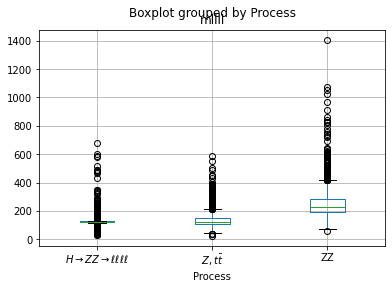

In [19]:
def boxplot(data):
    
    # boxplot of signal and background mllll
    plt.figure()
    for s in stack_order:
        if s != 'data': data[s]['Process'] = s
    data_all = pd.concat([data[r'$Z,t\bar{t}$'],data['ZZ'],data[r'$H \rightarrow ZZ \rightarrow \ell\ell\ell\ell$']])
    data_all.boxplot(by='Process',column=["mllll"])

    return

boxplot(data)

## The Training and Testing split
One of the first things to do is split your data into a training and testing set. This will split your data into train-test sets: 67%-33%. It will also shuffle entries so you will not get the first 67% of <span style="color:red">X</span> for training and the last 33% for testing. This is particularly important in cases where you load all signal events first and then the background events.

Here we split our data into two independent samples twice. The first split is to create a development and a evaluation set. All development and performance evaluation will be done with the development set. Once the hyper-parameters and other settings are frozen we can use the evaluation set to get an unbiased estimate of the performance.

The development set is further split into a training and testing set. The first will be used for training the classifier and the second to evaluate its performance.

In [20]:
from sklearn.model_selection import train_test_split

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y,
                                                test_size=0.33, random_state=42)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev,
                                                    test_size=0.33, random_state=492)

## Training Decision Trees
Here we set several hyper-parameters to non default values.

After instantiating our <span style="color:red">AdaBoostClassifier</span>, call the <span style="color:red">fit()</span> method with the training sample as an argument. This will train the tree, now we are ready to evaluate the performance on the held out testing set.

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

dt = DecisionTreeClassifier(max_depth=3)
                            #min_samples_leaf=0.05*len(X_train)

#dt.fit(X_train, y_train)

bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME',
                        n_estimators=800,
                        learning_rate=0.5)

bdt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=800)

The <span style="color:red">fit()</span> method returns the trained classifier. When printed out all the hyper-parameters are listed.

## Assessing a Classifier's Performance
Next let's create a quick report on how well our classifier is doing. It is important to make sure you use samples not seen by the classifier to get an unbiased estimate of its performance.

In [22]:
y_predicted = bdt.predict(X_test)
print (classification_report(y_test, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for test data: %.4f"%(roc_auc_score(y_test,
                                                    bdt.decision_function(X_test))))

              precision    recall  f1-score   support

  background       0.93      0.61      0.74      1010
      signal       0.96      1.00      0.98      9467

    accuracy                           0.96     10477
   macro avg       0.95      0.81      0.86     10477
weighted avg       0.96      0.96      0.95     10477

Area under ROC curve for test data: 0.9419


To illustrate that point, here's the same performance metrics evaluated on the training set instead. The estimates of the performance are more optimistic than on an unseen set of events.

In [23]:
y_predicted = bdt.predict(X_train)
print (classification_report(y_train, y_predicted,
                            target_names=["background", "signal"]))
print ("Area under ROC curve for training data: %.4f"%(roc_auc_score(y_train,
                                                    bdt.decision_function(X_train))))

              precision    recall  f1-score   support

  background       0.92      0.62      0.74      2148
      signal       0.96      0.99      0.98     19122

    accuracy                           0.96     21270
   macro avg       0.94      0.81      0.86     21270
weighted avg       0.96      0.96      0.95     21270

Area under ROC curve for training data: 0.9488


Another useful plot to judge the performance of a classifier is to look at the ROC curve directly.

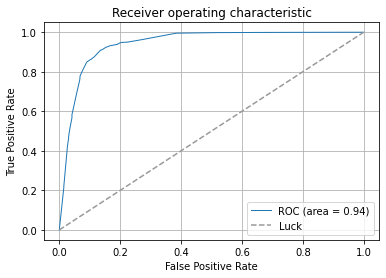

In [24]:
from sklearn.metrics import roc_curve, auc

decisions = bdt.decision_function(X_test)
# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, decisions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Overtraining Check
Comparing the BDT's output distribution for the training and testing set is a popular way in HEP to check for overtraining. The <span style="color:red">compare_test_train()</span> method will plot the BDT's decision function for each class, as well as overlaying it with the shape of the decision function in the training set.

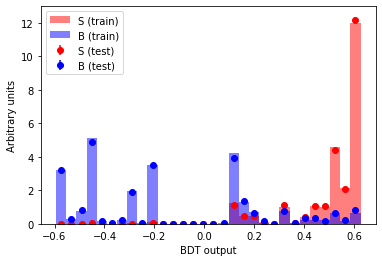

In [25]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=30):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    
    plt.hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')

    plt.xlabel("BDT output")
    plt.ylabel("Arbitrary units")
    plt.legend(loc='best')
    
compare_train_test(bdt, X_train, y_train, X_test, y_test)